In [ ]:
# Conexão com o Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

# Caminhos para os arquivos .h5
data_dir = '/content/drive/MyDrive/approach_nwot/dados'
color_frames_h5_path = os.path.join(data_dir, 'color_frames.h5')
masked_color_frames_h5_path = os.path.join(data_dir, 'masked_color_frames.h5')
thermal_frames_h5_path = os.path.join(data_dir, 'thermal_frames.h5')

# Função para carregar os frames dos arquivos .h5
def load_frames_from_h5(h5_path, dataset_name='frames'):
    with h5py.File(h5_path, 'r') as h5f:
        frames = np.array(h5f[dataset_name])
    return frames

# Função para normalizar os frames térmicos
def normalize_thermal_frames(frames):
    frames_normalized = []
    for frame in frames:
        if len(frame.shape) == 2 or frame.shape[2] == 1:
            frame_min = frame.min()
            frame_max = frame.max()
            if frame_max - frame_min > 0:
                frame_norm = (frame - frame_min) / (frame_max - frame_min)
                frame_norm = (frame_norm * 255).astype(np.uint8)
            else:
                frame_norm = np.zeros_like(frame, dtype=np.uint8)
            frame_norm_bgr = cv2.cvtColor(frame_norm, cv2.COLOR_GRAY2BGR)
        else:
            frame_min = frame.min()
            frame_max = frame.max()
            if frame_max - frame_min > 0:
                frame_norm = (frame - frame_min) / (frame_max - frame_min)
                frame_norm = (frame_norm * 255).astype(np.uint8)
            else:
                frame_norm = np.zeros_like(frame, dtype=np.uint8)
            frame_norm_bgr = frame_norm
        frames_normalized.append(frame_norm_bgr)
    return np.array(frames_normalized)

# Carregamento e Normalização dos Frames
print("Carregando frames dos arquivos .h5...")
color_frames = load_frames_from_h5(color_frames_h5_path)
masked_color_frames = load_frames_from_h5(masked_color_frames_h5_path)
thermal_frames = load_frames_from_h5(thermal_frames_h5_path)
print("Frames carregados com sucesso.")

# Verificar tipo e faixa de valores dos frames térmicos
print("Tipo de dados dos frames térmicos:", thermal_frames.dtype)
print("Valor mínimo dos frames térmicos:", thermal_frames.min())
print("Valor máximo dos frames térmicos:", thermal_frames.max())

# Normalizar frames térmicos
thermal_frames = normalize_thermal_frames(thermal_frames)
print("Frames térmicos normalizados.")

# Definir intervalos de recorte fixos para garantir resoluções consistentes
color_crop_rows = (0, 720)
color_crop_cols = (250, 500)

thermal_crop_rows = (0, 512)
thermal_crop_cols = (0, 250)

def crop_frames(frames, crop_rows, crop_cols):
    if len(frames.shape) == 4:
      # Frames com 4 dimensões (batch, altura, largura, canais)
      cropped_frames = frames[:, crop_rows[0]:crop_rows[1], crop_cols[0]:crop_cols[1], :]
    elif len(frames.shape) == 3:
      # Frames com 3 dimensões (Batch, altura, largura)
      cropped_frames = frames[:, crop_rows[0]:crop_rows[1], crop_cols[0]:crop_cols[1]]
    else:
      raise ValueError("Formato de frames não suportado para recorte.")
    return cropped_frames

cropped_color_frames = crop_frames(masked_color_frames, color_crop_rows, color_crop_cols)
cropped_thermal_frames = crop_frames(thermal_frames, thermal_crop_rows, thermal_crop_cols)

# Verificar as formas após o recorte
print("Resoluções dos Frames Recortados:")
print(f"Cropped Color Frames Shape: {cropped_color_frames.shape}")      # Esperado: (num_frames, 720, 250, 3)
print(f"Cropped Thermal Frames Shape: {cropped_thermal_frames.shape}")  # Esperado: (num_frames, 512, 250, 3)


Carregando frames dos arquivos .h5...
Frames carregados com sucesso.
Tipo de dados dos frames térmicos: uint8
Valor mínimo dos frames térmicos: 0
Valor máximo dos frames térmicos: 255
Frames térmicos normalizados.
Resoluções dos Frames Recortados:
Cropped Color Frames Shape: (908, 720, 250, 3)
Cropped Thermal Frames Shape: (908, 512, 250, 3)


In [ ]:

# =========================== Definição da Nova Resolução para os Frames Térmicos ===========================

# Defina a nova resolução desejada para os frames térmicos
nova_altura = 500
nova_largura = 250

print(f"Definindo nova resolução para os frames térmicos: {nova_altura}x{nova_largura} (Height x Width)")

# Função para redimensionar os frames térmicos para a nova resolução
def resize_thermal_frames(thermal_frames, target_size):
    resized_frames = []
    for idx, frame in enumerate(thermal_frames):
        resized_frame = cv2.resize(frame, target_size, interpolation=cv2.INTER_AREA)
        resized_frames.append(resized_frame)
    return np.array(resized_frames)

# Definir a resolução alvo baseada nos parâmetros definidos
target_size_thermal = (nova_largura, nova_altura)

# Redimensionar todos os frames térmicos para a nova resolução
resized_thermal_frames = resize_thermal_frames(cropped_thermal_frames, target_size_thermal)
print(f"Todos os frames térmicos foram redimensionados para: {resized_thermal_frames.shape[1:3]} (Height x Width)")

# =========================== Atualização das Resoluções Finais dos Frames ===========================

# Verificar se as larguras coincidem
if cropped_color_frames.shape[2] != resized_thermal_frames.shape[2]:
    print("A largura dos frames coloridos e térmicos não coincide após o recorte e redimensionamento.")
    print("Considere redimensionar os frames coloridos para corresponder à largura dos térmicos.")
else:
    print("A largura dos frames coloridos e térmicos coincide.")

# Definir os frames finais
# final_color_frames = cropped_color_frames
# final_thermal_frames = resized_thermal_frames

final_thermal_frames = cropped_thermal_frames
final_color_frames = cropped_color_frames

# Verificar as formas após o redimensionamento
print("Resoluções dos Frames Após Redimensionamento:")
print(f"Final Color Frames Shape: {final_color_frames.shape}")
print(f"Final Thermal Frames Shape: {final_thermal_frames.shape}")


In [ ]:
# =========================== Extração e Filtragem das Máscaras ===========================

# Extrair máscaras dos frames coloridos recortados
def extract_masks_from_frames(frames):
    # Detecta onde os pixels são [0, 0, 255] (vermelho)
    masks = np.all(frames == [0, 0, 255], axis=-1).astype(np.uint8) * 255
    return masks

cropped_masks = extract_masks_from_frames(final_color_frames)

# Filtrar frames que possuem máscaras após o recorte
mask_sums = np.sum(cropped_masks, axis=(1, 2))
frames_with_masks_indices = np.where(mask_sums > 0)[0]

final_color_frames = final_color_frames[frames_with_masks_indices]
final_thermal_frames = final_thermal_frames[frames_with_masks_indices]
cropped_masks = cropped_masks[frames_with_masks_indices]

print(f"Número de frames após filtragem de máscaras: {final_color_frames.shape[0]}")


Número de frames após filtragem de máscaras: 483


In [ ]:
# =========================== Definição das Regiões e Seus deltaX e deltaY ===========================

# Defina o tamanho dos blocos
block_size = 50  # 50x50 pixels

# Calcular o número de blocos vertical e horizontalmente
num_blocks_vert = int(np.ceil(nova_altura / block_size))  # 500 / 50 = 10
num_blocks_hor = int(np.ceil(nova_largura / block_size))  # 250 / 50 = 5

print(f"Dividindo os frames em {num_blocks_vert} blocos verticais e {num_blocks_hor} blocos horizontais.")

# Criar uma grade de blocos
blocks = []
for row in range(num_blocks_vert):
    for col in range(num_blocks_hor):
        y_start = row * block_size
        y_end = min((row + 1) * block_size, nova_altura)
        x_start = col * block_size
        x_end = min((col + 1) * block_size, nova_largura)
        blocks.append({
            'row': row,
            'col': col,
            'y_start': y_start,
            'y_end': y_end,
            'x_start': x_start,
            'x_end': x_end,
            'deltaX': 0,
            'deltaY': 0
        })

# Condições para aplicação dos deltas na imagem térmica
blocks_shifts = {
    #(14, 6): {'deltaX': 40, 'deltaY': 30},    # AQUI AGORA
    (23, 14): {'deltaX': 20, 'deltaY': 27},
    (7, 3): {'deltaX': 25, 'deltaY': 20},
    (6, 4): {'deltaX': 30, 'deltaY': 20},
    (27, 22): {'deltaX': 0, 'deltaY': 0},
    (32, 24): {'deltaX': 0, 'deltaY': 0},
    (37, 12): {'deltaX': 0, 'deltaY': 0},
    (30, 16): {'deltaX': 0, 'deltaY': 0},
    (25, 22): {'deltaX': 0, 'deltaY': 0},
    (38, 16): {'deltaX': 0, 'deltaY': 0},
    (20, 18): {'deltaX': 0, 'deltaY': 0},
    (33, 2): {'deltaX': 0, 'deltaY': 0},
    (34, 23): {'deltaX': 0, 'deltaY': 0},
    (33, 6): {'deltaX': 0, 'deltaY': 0},
    (33, 24): {'deltaX': 0, 'deltaY': 0},
    (36, 23): {'deltaX': 0, 'deltaY': 0},
    (40, 20): {'deltaX': 0, 'deltaY': 0},
    (36, 16): {'deltaX': 0, 'deltaY': 0},
    (15, 2): {'deltaX': 0, 'deltaY': 0},
    (40, 0): {'deltaX': 0, 'deltaY': 0},
    (30, 9): {'deltaX': 0, 'deltaY': 0},
    (29, 5): {'deltaX': 0, 'deltaY': 0},
    (27, 11): {'deltaX': 0, 'deltaY': 0},
    (37, 19): {'deltaX': 0, 'deltaY': 0},
    (35, 5): {'deltaX': 0, 'deltaY': 0},
}
# Atualizar os deltaX e deltaY nos blocos com base no mapeamento definido
for block in blocks:
    key = (block['row'], block['col'])
    if key in blocks_shifts:
        block['deltaX'] = blocks_shifts[key]['deltaX']
        block['deltaY'] = blocks_shifts[key]['deltaY']


Dividindo os frames em 10 blocos verticais e 5 blocos horizontais.


In [ ]:
# =========================== Função para Determinar o Bloco de uma Máscara ===========================

def get_block_of_mask(mask, blocks):
    """
    Determina em qual bloco a máscara está localizada com base no seu centroide.

    Args:
        mask (numpy.ndarray): Máscara binária de uma frame (H x W).
        blocks (list): Lista de dicionários que definem cada bloco.

    Returns:
        tuple: (row, col) do bloco onde a máscara está localizada. Retorna None se não encontrar.
    """
    # Encontrar contornos na máscara
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        return None

    # Considerar o maior contorno
    largest_contour = max(contours, key=cv2.contourArea)

    # Calcular o centroide
    M = cv2.moments(largest_contour)
    if M['m00'] == 0:
        return None
    cX = int(M['m10'] / M['m00'])
    cY = int(M['m01'] / M['m00'])

    # Determinar qual bloco contém o centroide
    for block in blocks:
        if (block['x_start'] <= cX < block['x_end']) and (block['y_start'] <= cY < block['y_end']):
            return (block['row'], block['col'])

    return None

# =========================== Função para Aplicar deltaX e deltaY Baseado no Bloco ===========================

def apply_shifts_based_on_block(frames, masks, blocks, blocks_shifts):
    """
    Aplica deslocamentos aos frames térmicos com base no bloco onde a máscara está localizada.

    Args:
        frames (numpy.ndarray): Frames térmicos a serem deslocados (num_frames, H, W, C).
        masks (numpy.ndarray): Máscaras binárias (num_frames, H, W).
        blocks (list): Lista de dicionários que definem cada bloco.
        blocks_shifts (dict): Dicionário mapeando (row, col) para {'deltaX': x, 'deltaY': y}.

    Returns:
        numpy.ndarray: Frames térmicos deslocados.
    """
    shifted_frames = []
    for idx, (frame, mask) in enumerate(zip(frames, masks)):
        block_key = get_block_of_mask(mask, blocks)
        if block_key is not None and block_key in blocks_shifts:
            deltaX = blocks_shifts[block_key]['deltaX']
            deltaY = blocks_shifts[block_key]['deltaY']
        else:
            deltaX = 0
            deltaY = 0

        print(f"Frame {idx}: Aplicando deltaX={deltaX}, deltaY={deltaY} no bloco {block_key}")

        translation_matrix = np.float32([[1, 0, deltaX], [0, 1, deltaY]])
        shifted_frame = cv2.warpAffine(frame, translation_matrix, (frame.shape[1], frame.shape[0]))
        shifted_frames.append(shifted_frame)

    return np.array(shifted_frames)


### FUNÇÃO PARA OBTER DADOS DOS BLOCOS COM MÁSCARAS

In [ ]:
# ------------------------ FUNÇÃO PARA OBTER TODOS OS BLOCOS COM MÁSCARAS ----------------
def get_all_blocks_with_masks(masks, blocks):
    """
    Retorna um conjunto de todas as chaves de blocos (row, col) onde as máscaras estão presentes.

    Args:
        masks (numpy.ndarray): Array de máscaras (num_frames, H, W).
        blocks (list): Lista de dicionários que definem cada bloco.

    Returns:
        set: Conjunto de chaves de blocos (row, col) onde as máscaras estão presentes.
    """
    blocks_with_masks = set()
    for mask in masks:
        block_key = get_block_of_mask(mask, blocks)
        if block_key is not None:
            blocks_with_masks.add(block_key)
    return blocks_with_masks

blocks_with_masks = get_all_blocks_with_masks(cropped_masks, blocks)
print("Blocos com máscaras presentes:", blocks_with_masks)


Blocos com máscaras presentes: {(4, 0), (3, 4), (4, 3), (3, 1), (5, 4), (5, 1), (8, 0), (9, 2), (8, 3), (2, 2), (1, 0), (1, 3), (7, 4), (6, 2), (7, 1), (4, 2), (3, 0), (3, 3), (5, 0), (5, 3), (8, 2), (9, 1), (2, 4), (1, 2), (2, 1), (6, 1), (7, 0), (6, 4), (7, 3), (3, 2), (4, 1), (5, 2), (4, 4), (9, 0), (8, 4), (9, 3), (8, 1), (1, 1), (2, 0), (2, 3), (7, 2), (6, 0), (6, 3)}


In [ ]:
from collections import defaultdict

def count_frames_per_block(masks, blocks):
    """
    Conta o número de frames que têm máscaras em cada bloco.

    Args:
        masks (numpy.ndarray): Array de máscaras (num_frames, H, W).
        blocks (list): Lista de dicionários que definem cada bloco.

    Returns:
        dict: Dicionário mapeando chaves de blocos (row, col) para contagens.
    """
    block_counts = defaultdict(int)
    for mask in masks:
        block_key = get_block_of_mask(mask, blocks)
        if block_key is not None:
            block_counts[block_key] += 1
    return block_counts


block_counts = count_frames_per_block(cropped_masks, blocks)
print("Número de frames com máscaras por bloco em formato decrescente:")
for block_key, count in sorted(block_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"Bloco {block_key}: {count} frames")



Número de frames com máscaras por bloco em formato decrescente:
Bloco (7, 3): 28 frames
Bloco (6, 4): 23 frames
Bloco (6, 3): 21 frames
Bloco (7, 2): 19 frames
Bloco (5, 0): 19 frames
Bloco (5, 3): 18 frames
Bloco (5, 2): 17 frames
Bloco (7, 4): 17 frames
Bloco (5, 1): 16 frames
Bloco (6, 0): 16 frames
Bloco (6, 2): 16 frames
Bloco (4, 4): 15 frames
Bloco (4, 2): 15 frames
Bloco (5, 4): 15 frames
Bloco (4, 3): 13 frames
Bloco (6, 1): 12 frames
Bloco (7, 1): 11 frames
Bloco (3, 4): 9 frames
Bloco (3, 0): 8 frames
Bloco (8, 4): 8 frames
Bloco (2, 3): 8 frames
Bloco (2, 4): 8 frames
Bloco (2, 2): 8 frames
Bloco (2, 0): 8 frames
Bloco (3, 1): 7 frames
Bloco (3, 2): 7 frames
Bloco (3, 3): 7 frames
Bloco (7, 0): 6 frames
Bloco (8, 0): 5 frames
Bloco (4, 1): 5 frames
Bloco (8, 3): 5 frames
Bloco (2, 1): 5 frames
Bloco (4, 0): 4 frames
Bloco (8, 2): 4 frames
Bloco (1, 1): 3 frames
Bloco (9, 1): 3 frames
Bloco (8, 1): 2 frames
Bloco (1, 3): 2 frames
Bloco (1, 2): 2 frames
Bloco (1, 0): 2 frames

### FUNÇÃO PARA FILTRAR

In [ ]:
# =========================== Função para Filtrar Frames por Bloco ===========================

def filter_frames_by_block(color_frames, thermal_frames, masks, blocks, target_block):
    """
    Filtra os frames que possuem máscaras no bloco especificado.

    Args:
        color_frames (numpy.ndarray): Frames coloridos filtrados (num_frames, H, W, C).
        thermal_frames (numpy.ndarray): Frames térmicos filtrados (num_frames, H, W, C).
        masks (numpy.ndarray): Máscaras binárias filtradas (num_frames, H, W).
        blocks (list): Lista de dicionários que definem cada bloco.
        target_block (tuple): Tupla (row, col) do bloco desejado.

    Returns:
        tuple: (color_filtered, thermal_filtered, masks_filtered)
    """
    color_filtered = []
    thermal_filtered = []
    masks_filtered = []
    for idx, (color_frame, thermal_frame, mask) in enumerate(zip(color_frames, thermal_frames, masks)):
        block_key = get_block_of_mask(mask, blocks)
        if block_key == target_block:
            color_filtered.append(color_frame)
            thermal_filtered.append(thermal_frame)
            masks_filtered.append(mask)
    return np.array(color_filtered), np.array(thermal_filtered), np.array(masks_filtered)

# Aplicando o filtro de frames por bloco
color_frames_filtered, thermal_frames_filtered, masks_filtered = filter_frames_by_block(final_color_frames, final_thermal_frames, cropped_masks, blocks,
                                                                                        target_block=(7, 3))

print(f"Número de frames após filtragem por bloco: {color_frames_filtered.shape[0]}")

Número de frames após filtragem por bloco: 28


In [ ]:

# =========================== Aplicação dos Deslocamentos Baseados nos Blocos ===========================

# Aplicar deslocamento nos blocos térmicos filtrados
shifted_thermal_frames_blocks = apply_shifts_based_on_block(thermal_frames_filtered, masks_filtered, blocks, blocks_shifts)
print("Frames térmicos filtrados deslocados com base nos blocos.")

# Aplicar deslocamentos a todos os frames com base nos blocos [DESCOMENTAR NO FINAL]
# shifted_thermal_frames_blocks = apply_shifts_based_on_block(final_thermal_frames, cropped_masks, blocks, blocks_shifts)
# print("Frames térmicos deslocados com base nos blocos.")

# =========================== Aplicação das Máscaras nos Frames Térmicos Deslocados ===========================

def apply_masks_to_frames(frames, masks, alpha=0.5):
    frames_with_masks = []
    for idx, (frame, mask) in enumerate(zip(frames, masks)):
        # Redimensionar a máscara para corresponder ao frame térmico
        resized_mask = cv2.resize(mask, (frame.shape[1], frame.shape[0]), interpolation=cv2.INTER_NEAREST)

        # Garantir que a máscara tenha 3 canais
        if len(resized_mask.shape) == 2:
            mask_color = cv2.cvtColor(resized_mask, cv2.COLOR_GRAY2BGR)
        else:
            mask_color = resized_mask

        # Criar uma imagem vermelha para a máscara
        red_mask = np.zeros_like(frame)
        red_mask[:, :] = [0, 0, 255]  # Vermelho em BGR

        # Criar uma máscara binária
        mask_binary = resized_mask == 255

        # Verificar se as dimensões correspondem
        if frame.shape[:2] != resized_mask.shape:
            print(f"Erro de dimensão no frame {idx}: frame.shape={frame.shape[:2]}, mask.shape={resized_mask.shape}")
            raise ValueError("As dimensões do frame e da máscara não correspondem após redimensionamento.")

        # Aplicar a sobreposição com transparência
        frame_with_mask = frame.copy()
        # Aplicar a sobreposição apenas nos pixels onde a máscara está presente
        frame_with_mask[mask_binary] = cv2.addWeighted(frame, 1 - alpha, red_mask, alpha, 0)[mask_binary]

        frames_with_masks.append(frame_with_mask)
    return np.array(frames_with_masks)

# [DESCOMENTAR NO FINAL]
# thermal_frames_with_masks_blocks = apply_masks_to_frames(shifted_thermal_frames_blocks, cropped_masks)
# print("Máscaras aplicadas nos frames térmicos deslocados com base nos blocos.")

thermal_frames_with_masks_blocks = apply_masks_to_frames(shifted_thermal_frames_blocks, masks_filtered)
print("Máscaras aplicadas nos frames térmicos FILTRADOS deslocados com base nos blocos.")


Frame 0: Aplicando deltaX=25, deltaY=20 no bloco (7, 3)
Frame 1: Aplicando deltaX=25, deltaY=20 no bloco (7, 3)
Frame 2: Aplicando deltaX=25, deltaY=20 no bloco (7, 3)
Frame 3: Aplicando deltaX=25, deltaY=20 no bloco (7, 3)
Frame 4: Aplicando deltaX=25, deltaY=20 no bloco (7, 3)
Frame 5: Aplicando deltaX=25, deltaY=20 no bloco (7, 3)
Frame 6: Aplicando deltaX=25, deltaY=20 no bloco (7, 3)
Frame 7: Aplicando deltaX=25, deltaY=20 no bloco (7, 3)
Frame 8: Aplicando deltaX=25, deltaY=20 no bloco (7, 3)
Frame 9: Aplicando deltaX=25, deltaY=20 no bloco (7, 3)
Frame 10: Aplicando deltaX=25, deltaY=20 no bloco (7, 3)
Frame 11: Aplicando deltaX=25, deltaY=20 no bloco (7, 3)
Frame 12: Aplicando deltaX=25, deltaY=20 no bloco (7, 3)
Frame 13: Aplicando deltaX=25, deltaY=20 no bloco (7, 3)
Frame 14: Aplicando deltaX=25, deltaY=20 no bloco (7, 3)
Frame 15: Aplicando deltaX=25, deltaY=20 no bloco (7, 3)
Frame 16: Aplicando deltaX=25, deltaY=20 no bloco (7, 3)
Frame 17: Aplicando deltaX=25, deltaY=20 

### FUNÇÃO PARA PLOTAR

In [ ]:
def plot_filtered_frames(color_frames_filtered, thermal_frames_filtered, thermal_frames_with_masks_blocks, start=0, end=10):
    """
    Plota os frames filtrados: frame colorido original, frame térmico e frame térmico com máscara aplicada.

    Args:
        color_frames_filtered (numpy.ndarray): Frames coloridos filtrados.
        thermal_frames_filtered (numpy.ndarray): Frames térmicos filtrados.
        thermal_frames_with_masks_blocks (numpy.ndarray): Frames térmicos filtrados com máscaras aplicadas.
        start (int): Índice do frame inicial.
        end (int): Índice do frame final (não incluso).
    """
    # Ajustar o intervalo
    start = max(start, 0)
    end = min(end, color_frames_filtered.shape[0])

    if start >= end:
        print("Erro: O índice de início deve ser menor que o índice de fim.")
        return

    num_frames = end - start
    print(f"Plotando frames de {start} a {end-1} (Total: {num_frames} frames)")

    fig, axs = plt.subplots(num_frames, 3, figsize=(15, 5 * num_frames))

    if num_frames == 1:
        axs = np.expand_dims(axs, axis=0)  # Garantir que axs seja 2D

    for i in range(num_frames):
        frame_idx = start + i

        # Frame colorido original
        color_frame = color_frames_filtered[frame_idx]
        color_frame_rgb = cv2.cvtColor(color_frame, cv2.COLOR_BGR2RGB)
        axs[i, 0].imshow(color_frame_rgb)
        axs[i, 0].set_title(f'Color Frame {frame_idx}')
        axs[i, 0].axis('off')

        # Frame térmico antes do deslocamento
        thermal_frame = thermal_frames_filtered[frame_idx]
        thermal_frame_rgb = cv2.cvtColor(thermal_frame, cv2.COLOR_BGR2RGB)
        axs[i, 1].imshow(thermal_frame_rgb)
        axs[i, 1].set_title(f'Thermal Frame {frame_idx}')
        axs[i, 1].axis('off')

        # Frame térmico após o deslocamento e aplicação da máscara
        thermal_frame_with_mask = thermal_frames_with_masks_blocks[frame_idx]
        thermal_frame_with_mask_rgb = cv2.cvtColor(thermal_frame_with_mask, cv2.COLOR_BGR2RGB)
        axs[i, 2].imshow(thermal_frame_with_mask_rgb)
        axs[i, 2].set_title(f'Thermal Frame with Mask {frame_idx}')
        axs[i, 2].axis('off')

    plt.tight_layout()
    plt.show()


### PLOT DOS FRAMES

Plotando frames de 0 a 27 (Total: 28 frames)


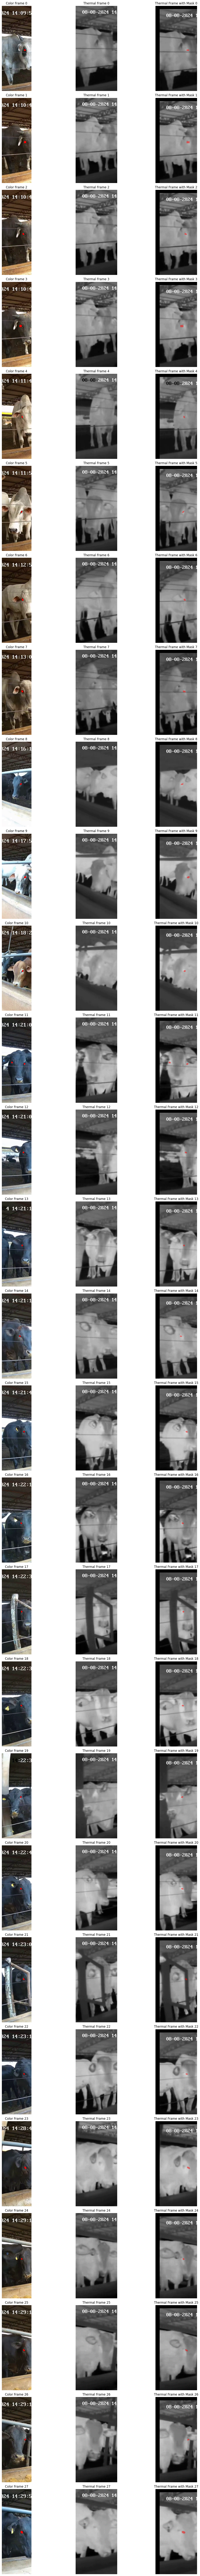

In [ ]:
# Defina o intervalo de frames que deseja visualizar
START_FRAME = 0   # Índice do frame inicial
END_FRAME = 30     # Índice do frame final (não incluso)

plot_filtered_frames(color_frames_filtered, thermal_frames_filtered, thermal_frames_with_masks_blocks, start=START_FRAME, end=END_FRAME)


## PLOT ANTIGO (GERAL, SEM FILTERED)

In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Paths to the .h5 files
data_dir = '/content/drive/MyDrive/approach_nwot/dados'
color_frames_h5_path = os.path.join(data_dir, 'color_frames.h5')
masked_color_frames_h5_path = os.path.join(data_dir, 'masked_color_frames.h5')
thermal_frames_h5_path = os.path.join(data_dir, 'thermal_frames.h5')

# Function to load frames from .h5 file
def load_frames_from_h5(h5_path, dataset_name='frames'):
    with h5py.File(h5_path, 'r') as h5f:
        frames = np.array(h5f[dataset_name])
    return frames

# Load the frames
print("Loading frames from .h5 files...")
color_frames = load_frames_from_h5(color_frames_h5_path)
masked_color_frames = load_frames_from_h5(masked_color_frames_h5_path)
thermal_frames = load_frames_from_h5(thermal_frames_h5_path)
print("Frames loaded successfully.")

# Verify that all datasets have the same number of frames
num_color = color_frames.shape[0]
num_masked = masked_color_frames.shape[0]
num_thermal = thermal_frames.shape[0]

if num_color != num_masked or num_color != num_thermal:
    print(f"Warning: Inconsistent number of frames among datasets.")
    print(f"Color Frames: {num_color}, Masked Color Frames: {num_masked}, Thermal Frames: {num_thermal}")
else:
    print(f"All datasets have {num_color} frames.")

# Function to plot frames
def plot_frames(color_frames, masked_color_frames, thermal_frames, start=0, end=10):
    """
    Plota os frames coloridos, frames coloridos com máscara e frames térmicos lado a lado.

    Args:
        color_frames (numpy.ndarray): Array de frames coloridos.
        masked_color_frames (numpy.ndarray): Array de frames coloridos com máscara.
        thermal_frames (numpy.ndarray): Array de frames térmicos.
        start (int): Índice do frame inicial.
        end (int): Índice do frame final (não incluso).
    """
    # Ajustar o intervalo
    start = max(start, 0)
    end = min(end, color_frames.shape[0])

    if start >= end:
        print("Erro: O índice de início deve ser menor que o índice de fim.")
        return

    num_frames = end - start
    print(f"Plotando frames de {start} a {end-1} (Total: {num_frames} frames)")

    # Criar uma figura grande para todos os frames
    fig, axs = plt.subplots(num_frames, 3, figsize=(15, 5 * num_frames))

    if num_frames == 1:
        axs = np.expand_dims(axs, axis=0)  # Garantir que axs seja 2D

    for i in range(num_frames):
        frame_idx = start + i

        # Frame colorido original
        color_frame = color_frames[frame_idx]
        color_frame_rgb = cv2.cvtColor(color_frame, cv2.COLOR_BGR2RGB)
        axs[i, 0].imshow(color_frame_rgb)
        axs[i, 0].set_title(f'Color Frame {frame_idx}')
        axs[i, 0].axis('off')

        # Frame colorido com máscara
        masked_color_frame = masked_color_frames[i]
        masked_color_frame_rgb = cv2.cvtColor(masked_color_frame, cv2.COLOR_BGR2RGB)
        axs[i, 1].imshow(masked_color_frame_rgb)
        axs[i, 1].set_title(f'Masked Color Frame {frame_idx}')
        axs[i, 1].axis('off')

        # Frame térmico
        thermal_frame = thermal_frames[i]
        thermal_frame_rgb = cv2.cvtColor(thermal_frame, cv2.COLOR_BGR2RGB)
        axs[i, 2].imshow(thermal_frame_rgb)
        axs[i, 2].set_title(f'Thermal Frame {frame_idx}')
        axs[i, 2].axis('off')

    plt.tight_layout()
    plt.show()




In [ ]:
# Exemplo de uso:
# Especifique o intervalo de frames que deseja plotar
START_FRAME = 0   # Índice do frame inicial
END_FRAME = 5     # Índice do frame final (não incluso)

plot_frames(color_frames, masked_color_frames, thermal_frames, start=START_FRAME, end=END_FRAME)